在机器学习中，集成方法是一种将多个学习算法组合在一起以获取更好表现的一种方法。机器学习下的集成方法主要是指有限的模型相互结合，而且可以有很多不同的结构。除了大家比较熟悉的Bagging，Boosting之外，近些年来，Stacking这种集成方法开始在各大机器学习竞赛中崭露头角，并取得了许多不错的成绩。下面我们来一步步的了解一下Stacking这种集成方法。

# 目录

[1. 集成方法](#1)

[2. Stacking](#2)

[3. 案例分析](#3)

<div id="1"></div>

# 1.集成方法

集成方法是将几种机器学习模型组合成一个预测模型的元算法，与单一模型相比，该方法可以提供更好的预测效果，也正因为如此，集成方法在许多著名的机器学习比赛中能够取得很好的名次。集成方法可以分为两类：
1. 串行集成方法：参与训练的基础学习器按照顺序生成，比如AdaBoost，其原理是利用基础学习器之间的依赖关系，通过对之前训练中错误标记的样本赋予较高的权重，以此来提高模型整体的预测效果。

2. 并行集成方法：参与训练的基础学习器并行生成，比如随机森林，其原理是利用基础学习器之间的独立性，通过对预测进行平均来显著降低模型的方差。

大多数集成方法使用相同类型的基础学习器来进行同质集成，还有一些使用不同类型学习器的集成方法，称为异构集成，比如我们将要介绍的Stacking。
<div id="2"></div>

# 2.Stacking

Stacking是一种集成学习技术，通过元分类器或元回归器聚合多个分类或回归模型。基础层模型(level model)基于完整的训练集进行训练，然后元模型(meta-classifier)基于基础层模型的输出进行训练。当基础层模型显著不同时，Stacking是最有效的。为了说明Stacking的完整步骤，我们来看下面一张图：


![1](./stacking.jpg)

图的上半部分是利用几个基础模型各自进行五折交叉验证，我们以Model1为例，假如用XGBoost作为基础模型Model1，五折交叉验证就是先拿出四折作为训练集，另外一折作为测试集。假设整个训练集包含10000行数据，测试集包含2500行数据，那么每一次交叉验证其实就是对训练集进行划分，用8000行数据进行训练，2000行数据进行测试。
每一次的交叉验证包含两个过程：
1. 基于划分后的训练集训练模型；

2. 基于训练好的模型对划分后的测试集进行预测，将会得到一个一维2000行的数据，记为a1；

3. 基于训练好的模型对原始的测试集进行预测，将会得到一个一维2500行的数据，记为b1；

因为是五折交叉验证，所以上述过程将会进行五次，最终会生成一个五列2000行的数据a1,a2,a3,a4,a5,即对训练集的一个完整预测，以及一个五列2500行的数据b1,b2,b3,b4,b5，即对测试集的五次预测。

我们把a1,a2,a3,a4,a5拼凑起来，会形成一个10000行一列的矩阵，记为A1。而对于b1,b2,b3,b4,b5这部分数据，我们将其各部分相加取一个平均，会得到一个2500行一列的矩阵，记为B1。

基础层中还包含着其它模型，假设还有Model2：LR，Model3：RF，Model4：GBDT，Model5：SVM，对于这四个模型，我们可以重复以上的步骤，最终会得到新的A2，A3，A4，A5，B2，B3，B4，B5矩阵。在这之后，我们把A1，A2，A3，A4，A5合并成一个10000行五列的矩阵作为新的训练集，再把B1，B2，B3，B4，B5合并成一个2500行五列的矩阵作为新的测试集，让下一层的元模型基于他们进一步训练，最终得到预测结果。

以上即为Stacking的完整步骤！

<div id="3"></div>

# 3.案例分析

了解了Stacking的原理和步骤，下面我们通过一个案例来看看Stacking是如何实现的。案例的背景是对美国爱荷华州埃姆斯地区的房价进行预测，训练集中有1460条数据，81个特征，目标特征为房价，是连续特征，所以这是一个回归任务。

In [47]:
## 载入所需要的模块和函数
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

train = pd.read_csv('./train.csv')

## 查看所有特征的名称及数据类型
names = train.columns   ## 特征名称
types = train.dtypes    ## 数据类型

## 删除无用特征“ID”
train.drop('Id', axis=1, inplace=True)

### 数据预处理：

异常点：
介绍数据的文档中表明训练集中可能存在异常点，它们对模型的预测会产生不好的效果，所以我们要把它们从训练集中去掉。

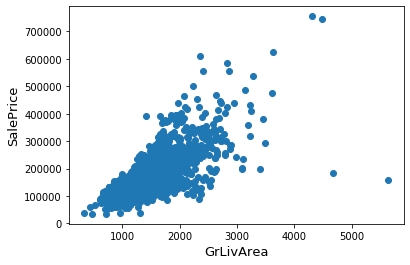

In [48]:
## 寻找异常点
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

通过散点图可以发现，`Saleprice`应该随着`GrLivArea`的增大而增大，显然图的右下角的两个点为异常点，要将它们删除。m

In [49]:
## 删除异常点
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

目标特征：`SalePrice`是我们需要去预测的，所以我们先要对这个特征进行一些分析。

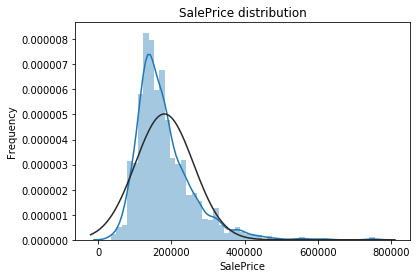

In [50]:
## 画出目标特征的密度直方图与核密度估计曲线，并画出正态曲线进行对比
sns.distplot(train['SalePrice'] , fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

## QQ-图
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

从上面两幅图可以看出`SalePrice`的分布不是正态分布，而且是右偏的。线性模型比较喜爱正态分布的数据，所以我们需要对这个特征进行变换，使其近似满足正态分布。

我们选择对目标特征进行对数变换：

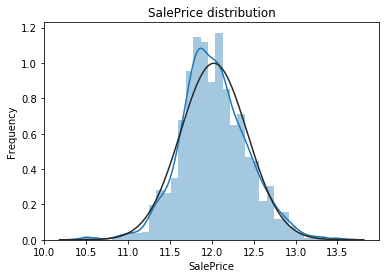

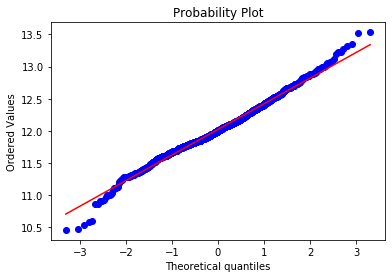

In [51]:
## 对数变换
train["SalePrice"] = np.log1p(train["SalePrice"])

## 再画出密度直方图和QQ-图观察效果
sns.distplot(train['SalePrice'] , fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

对数变换后的目标特征已经很接近于一个正态分布了。

### 特征工程

缺失值处理：我们首先看看训练集中的缺失值统计：

In [52]:
## 缺失值统计

# 计算缺失值的百分比
train_na = (train.isnull().sum() / len(train)) * 100
# 去掉没有缺失值的索引，其余的按降序排列
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]   
# 生成数据框
missing_data = pd.DataFrame({'Missing Ratio' :train_na}) 
# 输出前20行
missing_data.head(20)                                                                         

Missing Ratio
PoolQC            99.588477
MiscFeature       96.296296
Alley             93.758573
Fence             80.727023
FireplaceQu       47.325103
LotFrontage       17.764060
GarageYrBlt        5.555556
GarageType         5.555556
GarageFinish       5.555556
GarageQual         5.555556
GarageCond         5.555556
BsmtFinType2       2.606310
BsmtExposure       2.606310
BsmtFinType1       2.537723
BsmtCond           2.537723
BsmtQual           2.537723
MasVnrArea         0.548697
MasVnrType         0.548697
Electrical         0.068587

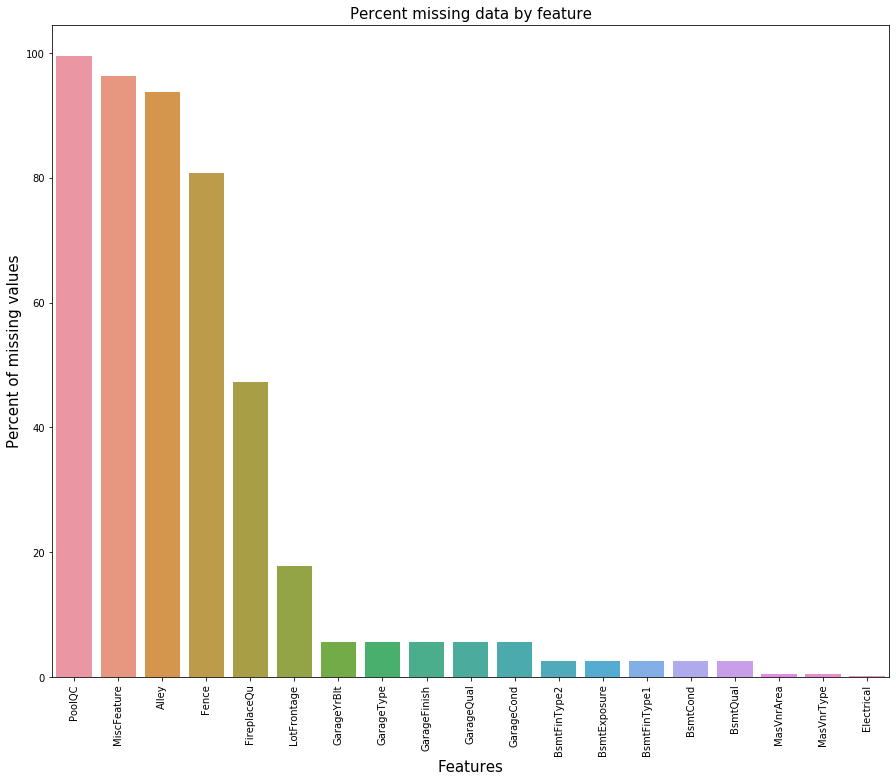

In [53]:
## 缺失值条形图
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

下面我们进行缺失值的插补：

`PoolQC(泳池质量)`：‘NA’意味着没有泳池，所以其缺失率才会达到99%，我们用‘None’来替代‘NA’，对其它有此情况的特征也进行相应的插补。

In [54]:
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

`LotFrontage(连接到房产的街道的线性脚)`：我们用邻近地区的`LotFrontage`的中位数来进行插补。

In [55]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

`GarageType(车库类型)`，` GarageFinish(车库内部装修)`，` GarageQual(车库质量)`和`GarageCond(车库条件)`：用‘None’来进行插补。

In [56]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')

`GarageYrBlt(车库修建年份)`， `GarageArea(车库面积)`和`GarageCars(车库容量)`：我们用0对缺失值进行插补。

In [57]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)

`BsmtFinSF1(1型地下室面积)`，`BsmtFinSF2(2型地下室面积)`，`BsmtUnfSF(未完成的地下室面积)`，`TotalBsmtSF(地下室总面积)`，`BsmtFullBath(全地下室浴室)`和`BsmtHalfBath(半地下室浴室)`：我们用0对缺失值进行插补。

In [58]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)

`BsmtQual(地下室质量)`，`BsmtCond(地下室条件)`，`BsmtExposure(失修的地下室墙壁)`，`BsmtFinType1(地下室完成区域质量)`和`BsmtFinType2(地下室第二个区域完成质量)`：我们用‘None’对缺失值进行插补。

In [59]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')

`MasVnrArea(砌体面积)`和`MasVnrType(砌体类型)`：我们用0来插补Area中的缺失值，用‘None’来插补Type中的缺失值。

In [60]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

`MSZoning(地区分类)`：我们用众数来进行插补。

In [61]:
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

`Utilities(可用设备)`：这个特征对模型预测没有帮助，我们可以放心删除它。

In [62]:
train = train.drop(['Utilities'], axis=1)

`Functional(家庭功能评级)`：数据集描述中表明‘NA’意味着‘typical’。

In [63]:
train["Functional"] = train["Functional"].fillna("Typ")

`Electrical(电力系统)`：只有一个缺失值，我们选择用众数进行插补。

In [64]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

`KitchenQual(厨房质量)`: 只有一个缺失值，我们选择用众数进行插补。

In [65]:
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])

`Exterior1st(房屋外墙)`和`Exterior2nd(多于一种的房屋外墙)`：用众数进行插补。

In [66]:
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])

`SaleType(销售类型)`：用众数进行插补。

In [67]:
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

`MSSubClass(建筑类)`：用‘None’进行插补。

In [68]:
train['MSSubClass'] = train['MSSubClass'].fillna("None")

最后我们再检查一下是否还存在缺失值：

In [69]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

结果显示已经不存在缺失值了。

之后我们将部分数值特征转换为分类特征：

In [70]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['OverallCond'] = train['OverallCond'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

进行分类特征的编码：

In [71]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

添加重要特征：因为与面积相关的特征对于房价的预测非常重要，所以我们又增加了每栋房子地下室，一层和二层的总面积这个特征。

In [72]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

数值特征的偏度：

In [73]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# 查看所有数值特征的偏度
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Skew
MiscVal       24.434913
PoolArea      15.932532
LotArea       12.560986
3SsnPorch     10.286510
LowQualFinSF   8.995688
LandSlope      4.805032
KitchenAbvGr   4.480268
BsmtFinSF2     4.247550
ScreenPorch    4.114690
BsmtHalfBath   4.095895

我们对偏度大于0.75的特征进行Box-Cox变换，使变换后的特征近似服从正态分布。

In [74]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15              # λ的取值为0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

对分类特征进行哑编码：

In [75]:
train = pd.get_dummies(train)
print(train.shape)

(1458, 221)


### 建模

我们利用Python中的Sklearn模块进行建模。

In [76]:
## 载入相应的模块和函数
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

## 分离训练数据和标签
y_train = train.SalePrice
train.drop('SalePrice', axis=1, inplace=True)

我们还定义了交叉验证的策略，运用cross_val_score这个函数进行交叉验证，但其没有shuffle这个参数，于是我们又为此添加了一行代码，以便在交叉验证之前打乱训练集的顺序。

In [77]:
n_folds = 5

def rmsle_cv(model):
    # 自己定义K折策略
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    # 定义评价标准
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

基础模型：
* LASSO：这个模型对异常点会比较敏感，所以在建模前先利用四分位数对数据进行缩放。
  
  RobustScaler()：
   根据四分位数来缩放数据，常常在数据有较多异常点的情况下使用。

In [78]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

* Elastic Net：同样在建模前先对数据进行标准化。

In [79]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

* Kernel Ridge Regression：

In [80]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting Regression：采用huber损失使模型在面对异常点时表现的更稳健。

  huber loss定义为：
  
  $$
L_{\delta}(y, f(x))=\begin{cases}
\dfrac{1}{2}(y - f(x))^2 & |y - f(x)| \leq \delta\\
\delta(|y - f(x)| - \dfrac{1}{2}\delta) & \text{others}
\end{cases}
$$

In [81]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* SVR:

In [82]:
SVR = SVR(C=1, kernel='rbf',gamma = 'scale')

* Random Forest:

In [83]:
rf = RandomForestRegressor(max_depth=5, n_estimators=2000)

基础模型得分：

In [84]:
score = []
model = [GBoost, KRR, ENet, lasso, rf, SVR]

for i in model:
    result = rmsle_cv(i)
    score.append(result.mean())

In [85]:
model_name = ['Gradient Boosting Regression', 'Kernel Ridge Regression', 'Elastic Net','LASSO','Random Forest','SVR']
result_score = pd.DataFrame({'model': model_name, 'score': score}, index=[1,2,3,4,5,6])
result_score

model     score
1  Gradient Boosting Regression  0.013226
2       Kernel Ridge Regression  0.013904
3                   Elastic Net  0.013976
4                         LASSO  0.014061
5                 Random Forest  0.017517
6                           SVR  0.033885

Stacking: 

得到了基础模型的效果，我们考虑使用Stacking这种集成方法是否能进一步提升模型的效果。利用Mlxtend库中的StackingClassifier可以快速的对基础模型进行Stacking，其主要有以下两种用法：
* 使用基础层模型产生的特征输出作为第二层元模型的输入数据。

* 使用基础层模型产生的类别概率值作为第二层元模型的输入数据，这种情况下需要将StackingClassifier的参数use/_probas设置为True。如果将参数average/_probas设置为True，那么这些基分类器对每一个类别产生的概率值会被平均，否则会被拼接。例如有两个基分类器产生的概率输出为：

      classifier 1: [0.2, 0.5, 0.3] ， classifier 2: [0.3, 0.4, 0.4]

        1) average = True：产生的输入特征为：[0.25, 0.45, 0.35]；
  
        2) average = False：产生的输入特征为：[0.2, 0.5, 0.3, 0.3, 0.4, 0.4]。

为了提升预测效果，但又不会让模型过于复杂，我们利用ElasticNet，Kernel Ridge Regression和Gradient Boosting Regression作为基础层模型，LASSO作为第二层的元模型进行Stacking，观察其交叉验证的效果。

In [86]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[ENet, GBoost, KRR], meta_classifier=lasso)
score = rmsle_cv(sclf)
print("Stacking score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Stacking score: 0.0132 (0.0009)



结果表明Stacking的预测效果好于任何一种单一模型。总之，在对实际数据进行建模时，Stacking等集成方法对可以很好地提高预测效果，聚合各种不同的模型可能会产生许多意想不到的效果。

Stacking模型的调参：

Stacking模型的调参包括对基础层模型和元模型的调参；对于基模型，因为我们在生成元模型的特征的时候要使用相同的K折划分，所以我们使用交叉验证和网格搜索来调参时最好使用与生成元模型的特征相同的K-fold。对于元模型的调参，使用交叉验证+网格搜索来调参时，为了降低过拟合的风险，我们最好也使用与元特征生成时同样的K-fold。